In [1]:
import os
import numpy as np
import xarray as xr

from satpy import enhancements, composites
from satpy.writers import to_image

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import from_levels_and_colors

C:\Users\metb4\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
folder = 'data/'
filelist = os.listdir(folder)
filelist

['NC_H09_20240221_0700_R21_FLDK.06001_06001.nc']

In [4]:
## Open Data
ds = xr.open_dataset(folder+filelist[0])

## Top Cloud Temperature

In [14]:
# Get areas
ds_crop = ds.sel(longitude=slice(100,115),latitude=slice(0,-15))

# Get coordinate
lat = ds_crop.tbb_13['latitude'].values
lon = ds_crop.tbb_13['longitude'].values

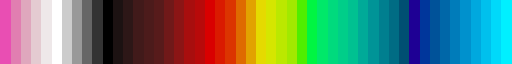

In [10]:
# Define colormap
tb_levels = [-100,-98,-96,-94,-92,-90,-88,-86,-84,-82,
             -80,-78,-76,-74,-72,-70,-68,-66,-64,-62,
             -60,-58,-56,-54,-52,-50,-48,-46,-44,-42,
             -40,-38,-36,-34,-32,-30,-28,-26,-24,-22,
             -20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0]
             #0,5,10,15,20,25,30,35,40,45,50]

tb_rgb = [#'#2d2d2d','#373737','#414141','#4b4b4b','#565656','#606060','#6b6b6b','#767676','#828282','#8d8d8d','#999999',
         '#00f0ff','#00d9fa','#00c0ed','#00a8de','#0091cd','#007cba','#0067a8','#005299','#00369b','#1e0094',
          '#004f72','#006c84','#007f8f','#009497','#00aa98','#00c191','#00ce89','#00da7d','#00e869','#00f542',
         '#4fee00','#a1e900','#bbe800','#d5e600','#e5da00','#e2a200','#df6a00','#dc3400','#da1a00','#d90000',
         '#b80a0a','#a80e0e','#8b1515','#701919','#571b1b','#4c1b1b','#411a1a','#2d1717','#1c1212','#000000',
         '#333333','#666666','#999999','#cccccc','#ffffff','#eee8e9','#e4cbd1','#dfa7bd','#e17eb1','#e94eb3','#f718c6']

tb_map, tb_norm = from_levels_and_colors(tb_levels, tb_rgb[::-1],extend="min")
tb_map

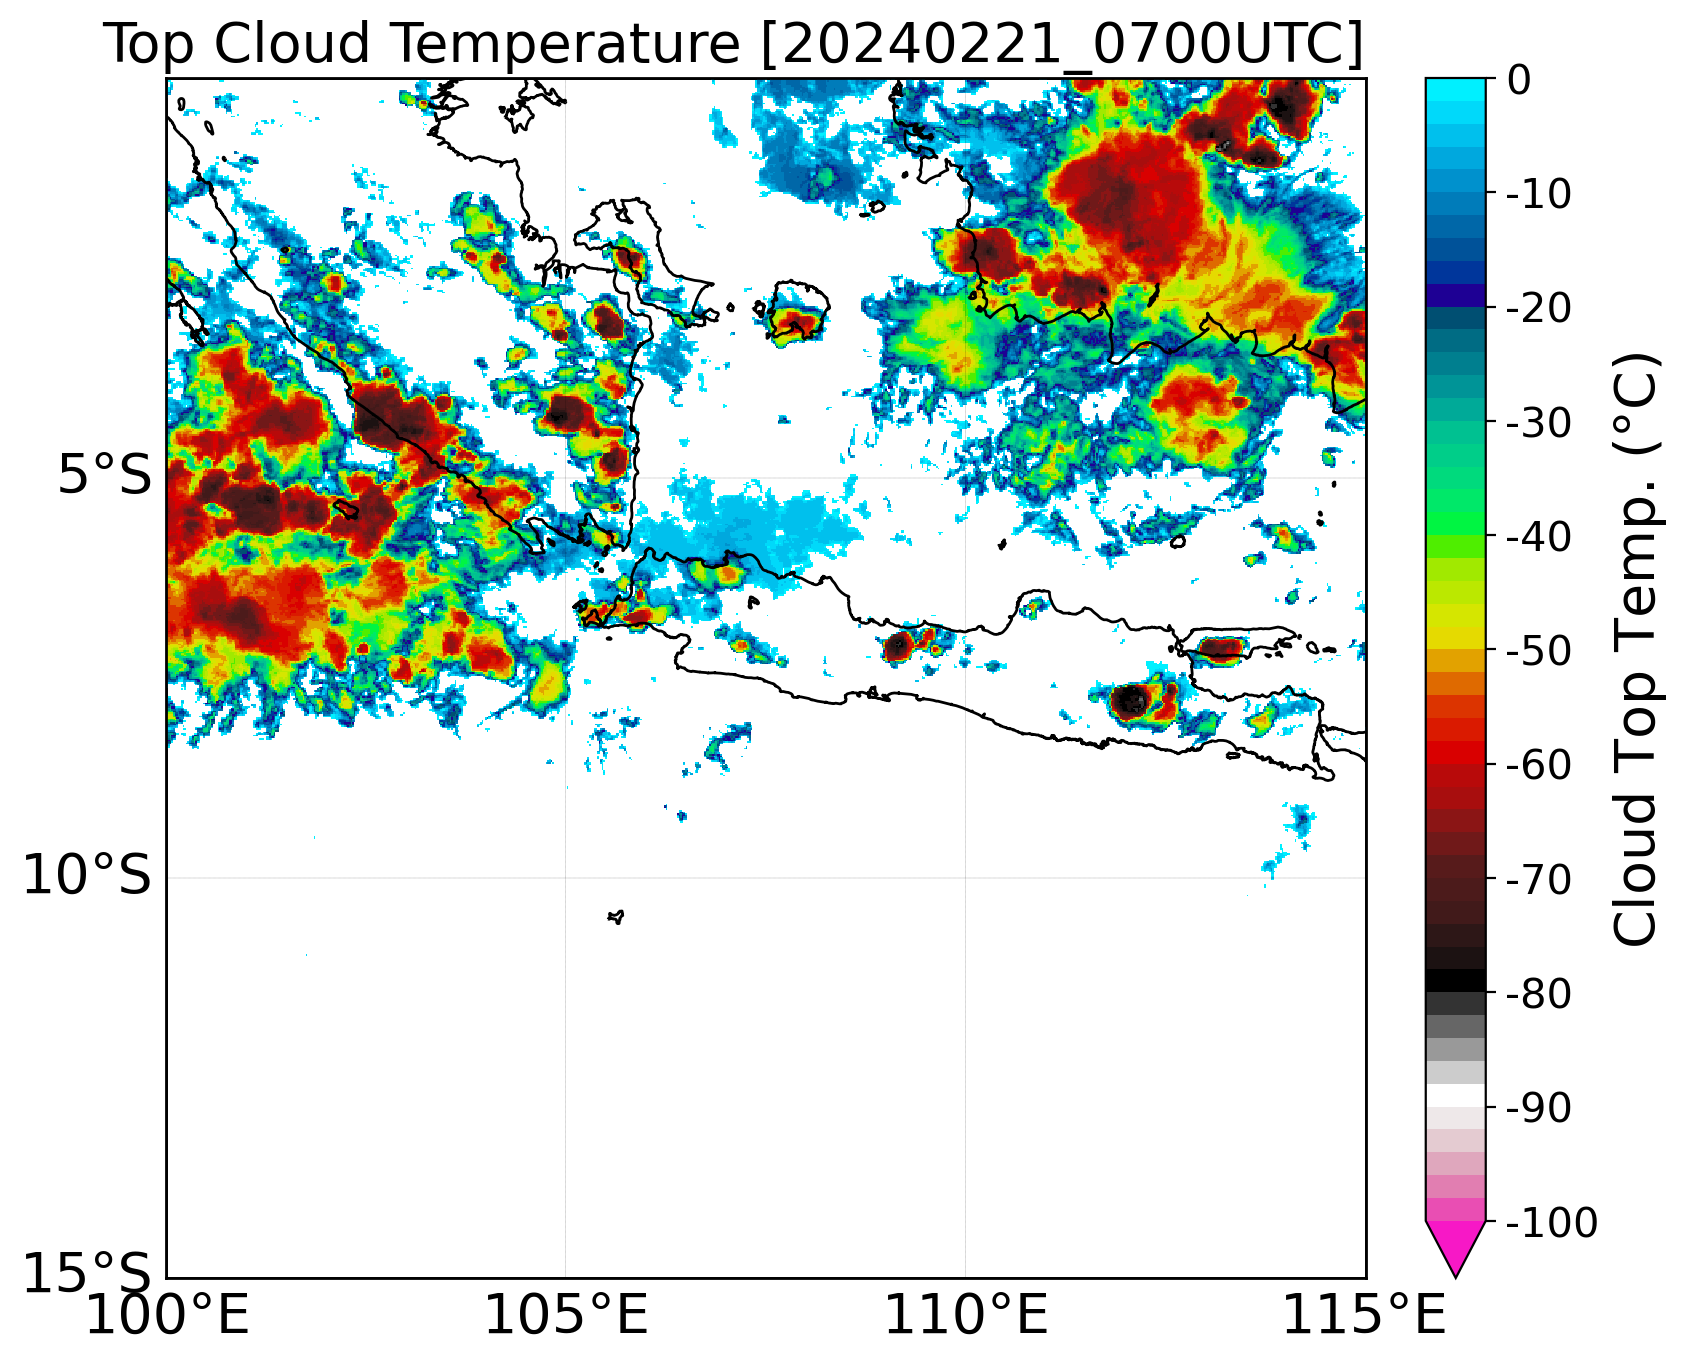

In [20]:
# Plot with Basemap
bm = Basemap(projection='cyl',llcrnrlon=lon[0],llcrnrlat=lat[-1],urcrnrlon=lon[-1],urcrnrlat=lat[0],resolution='h')
x,y = np.meshgrid(lon,lat)
x,y = bm(x,y)

fig= plt.figure(figsize=(20,20), dpi=200)
ax = fig.add_axes([0, 0, 1.5, 0.3]) 

bm.drawcoastlines()
bm.drawmapboundary(color='k', linewidth=1.0, zorder=None, ax=None)

parallels = np.arange(-20,21,5)
bm.drawparallels(parallels,labels=[True,False,False,True],fontsize=20, linewidth=0.1)
meridians = np.arange(95,151,5)
bm.drawmeridians(meridians,labels=[True,False,False,True],fontsize=20, linewidth=0.1)

contourf = bm.colorbar(bm.pcolormesh(x,y, ds_crop['tbb_13']-273.15, vmin=-100,vmax=0, cmap=tb_map, zorder=1), 
                    location='right', size='5%', pad='5%', ticks=[-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0])
contourf.set_label('Cloud Top Temp. ($\degree$C)',fontsize=20)
contourf.ax.set_yticklabels(['-100','-90','-80','-70','-60','-50','-40','-30','-20','-10','0'])
contourf.ax.tick_params(labelsize=15)
    
plt.title("Top Cloud Temperature [20240221_0700UTC]", loc='right', fontsize=20)

plt.show()
#fig.savefig('CTT.svg',dpi=300,orientation='landscape', bbox_inches='tight')

## Day Convective Storm

In [21]:
# Get areas
ds_crop = ds.sel(longitude=slice(100,115),latitude=slice(0,-15))

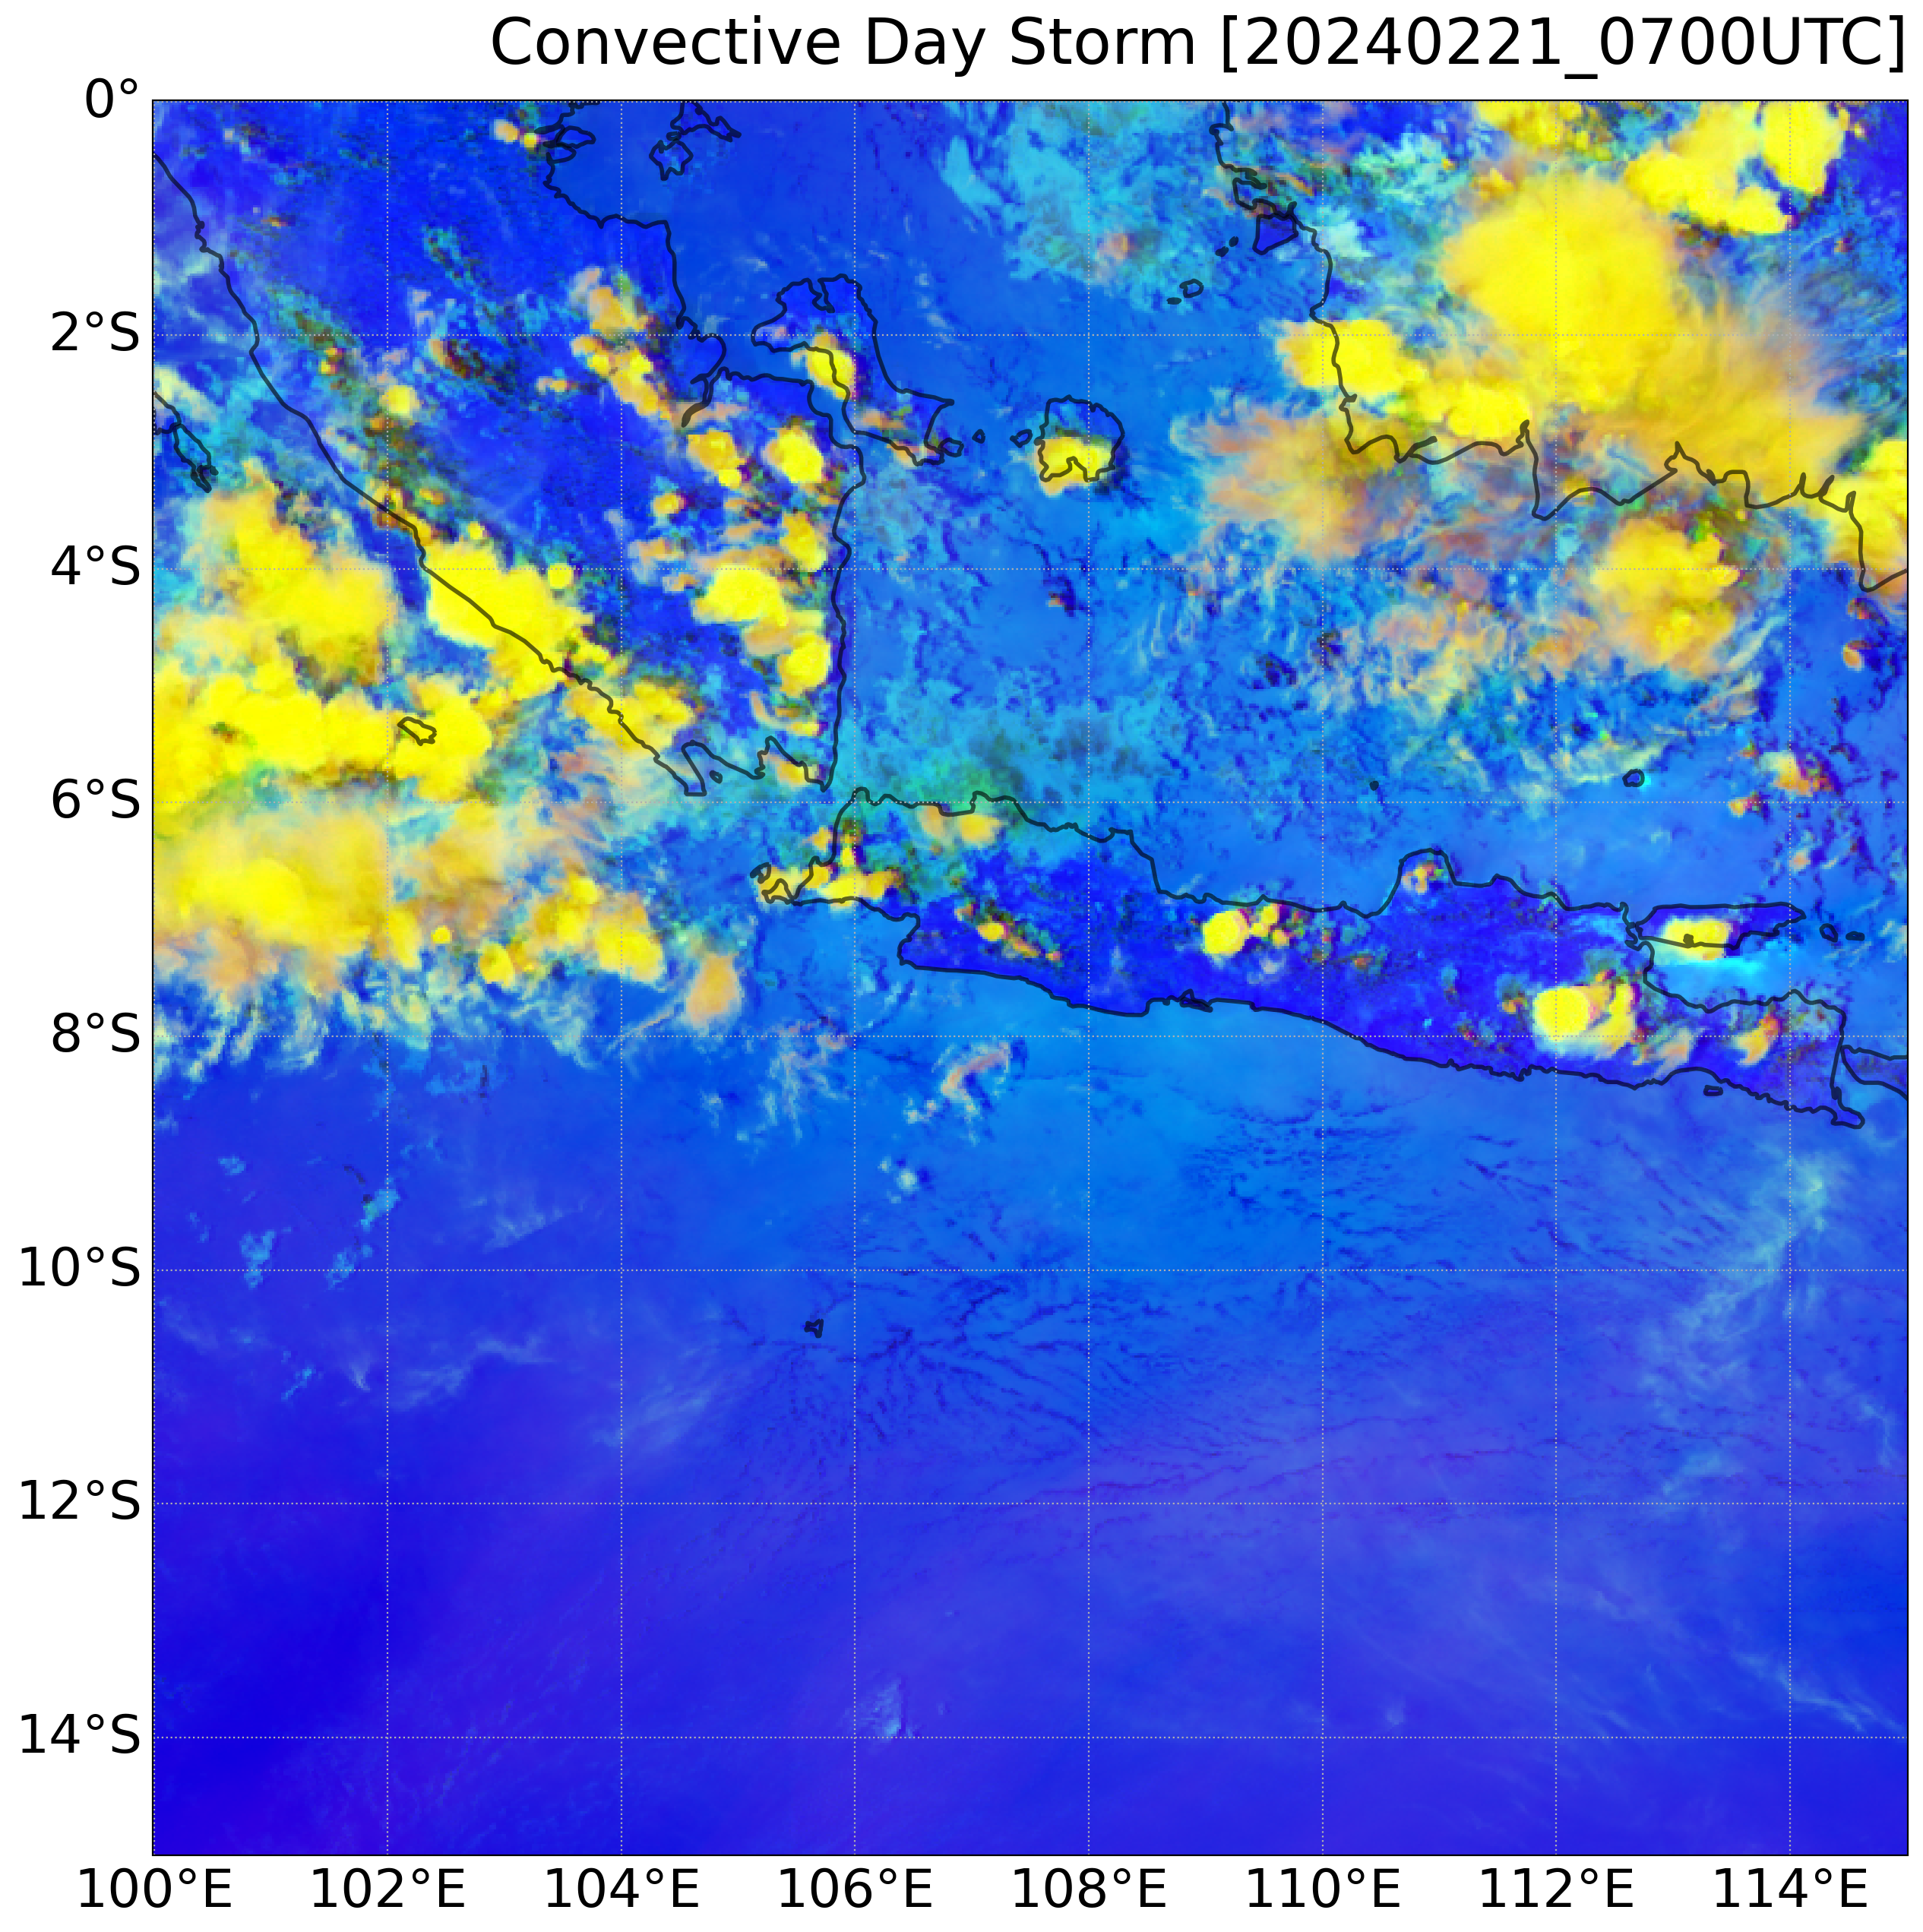

In [24]:
#R:B10-B08 B:B13-B07 B:B03-B05
comp_dif=composites.DifferenceCompositor('diffcomp')
    
r_band = comp_dif((ds_crop['tbb_10'],ds_crop['tbb_08']))
g_band = comp_dif((ds_crop['tbb_13'],ds_crop['tbb_07']))
b_band = comp_dif((ds_crop['albedo_03'],ds_crop['albedo_05']))

comp = composites.GenericCompositor('convective')
my_rgb = comp((r_band, g_band, b_band))
my_rgb=my_rgb.rename({'longitude': 'x','latitude': 'y'})

img = to_image(my_rgb)
enhancements.stretch(img,stretch= 'linear')
img.gamma([1,0.5,0.95])
img.invert([True,True,True])
img_data = img.data

# Plot
plt.figure(figsize=(15,15), dpi=200)
ax=plt.axes(projection=cartopy.crs.PlateCarree())

img_data.plot.imshow(transform=cartopy.crs.PlateCarree(),
                         vmin=0,
                         vmax=1,
                         rgb='bands')

ax.coastlines('10m', color='black',linewidth=2,alpha=0.6)
gl = ax.gridlines(draw_labels=True,linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25, 'color': 'black'}
gl.ylabel_style = {'size': 25, 'color': 'black'}
plt.title("Convective Day Storm [20240221_0700UTC]", loc='right', fontsize=30)
plt.show()
#fig.savefig('Convective.svg',dpi=300,orientation='landscape', bbox_inches='tight')

## True Color Raw

In [25]:
# Get areas
ds_crop = ds.sel(longitude=slice(100,115),latitude=slice(0,-15))

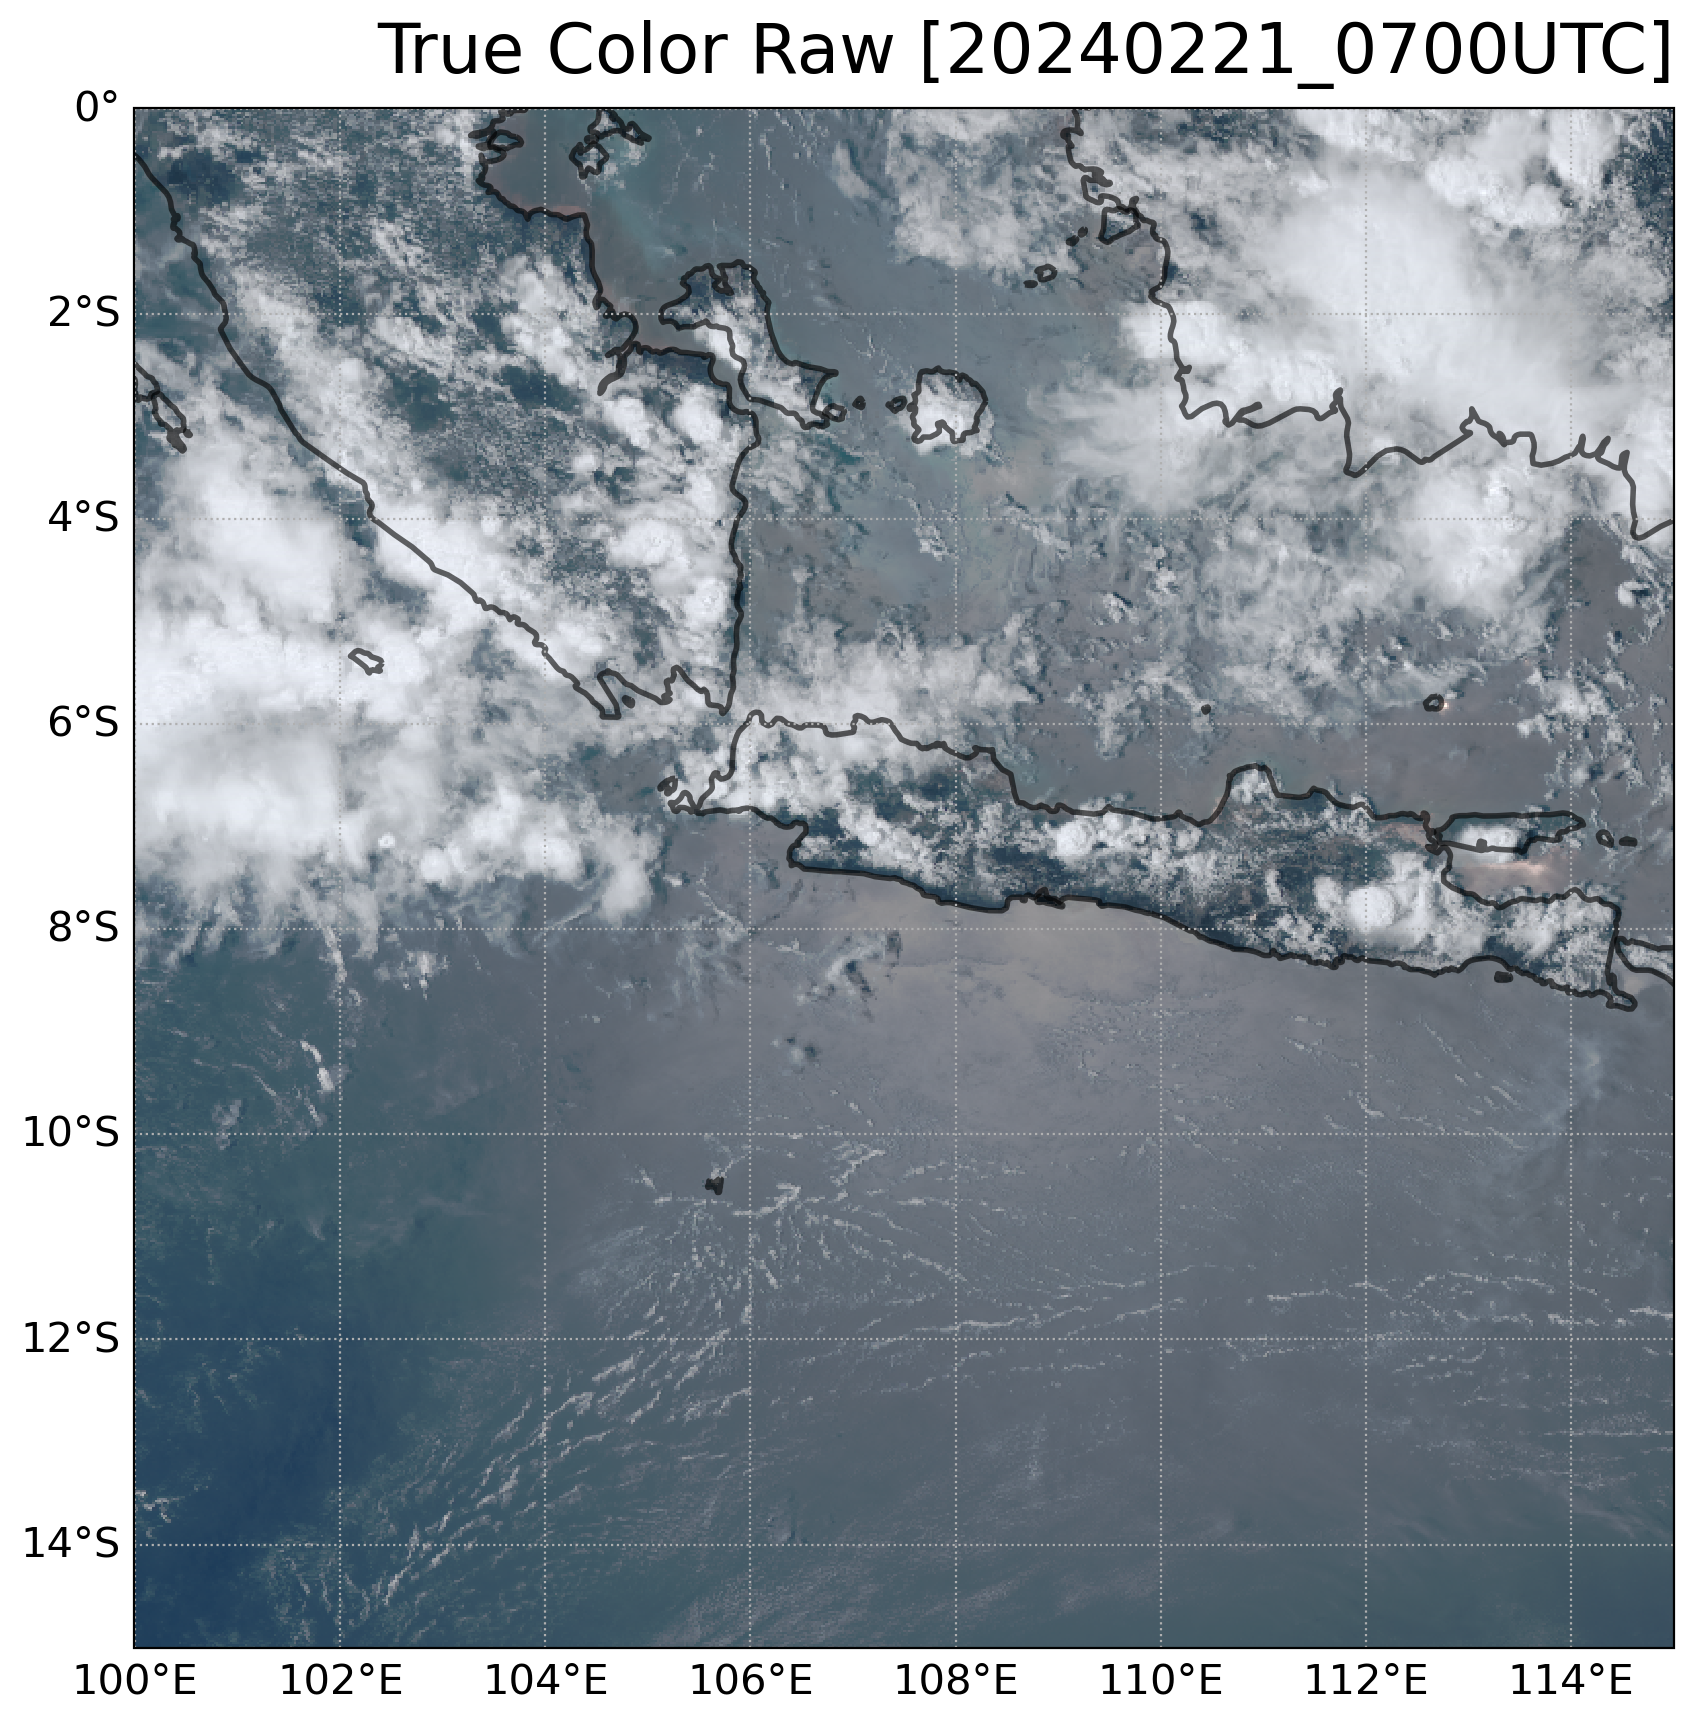

In [26]:
r_band = ds_crop['albedo_03']
g_band = ds_crop['albedo_02']
b_band = ds_crop['albedo_01']

comp = composites.GenericCompositor('true_color_raw')
my_rgb = comp((r_band, g_band, b_band))
my_rgb=my_rgb.rename({'longitude': 'x','latitude': 'y'})

img = to_image(my_rgb)
enhancements.piecewise_linear_stretch(img,
                                          xp = [0., 25., 55., 100., 255.],
                                          fp = [0., 90., 140., 175., 255.],
                                          reference_scale_factor= 255)
img_data = img.data

plt.figure(figsize=(10,10), dpi=200)
ax=plt.axes(projection=cartopy.crs.PlateCarree())

img_data.plot.imshow(transform=cartopy.crs.PlateCarree(),
                         vmin=0,
                         vmax=1,
                         rgb='bands')

ax.coastlines('10m', color='black',linewidth=2,alpha=0.6)
gl = ax.gridlines(draw_labels=True,linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
    
plt.title('True Color Raw [20240221_0700UTC]', loc='right',fontsize=25)
plt.show()
#fig.savefig('TrueColorRaw.svg',dpi=300,orientation='landscape', bbox_inches='tight')

## Natural Color Raw

In [32]:
# Get areas
ds_crop = ds.sel(longitude=slice(100,115),latitude=slice(0,-15))

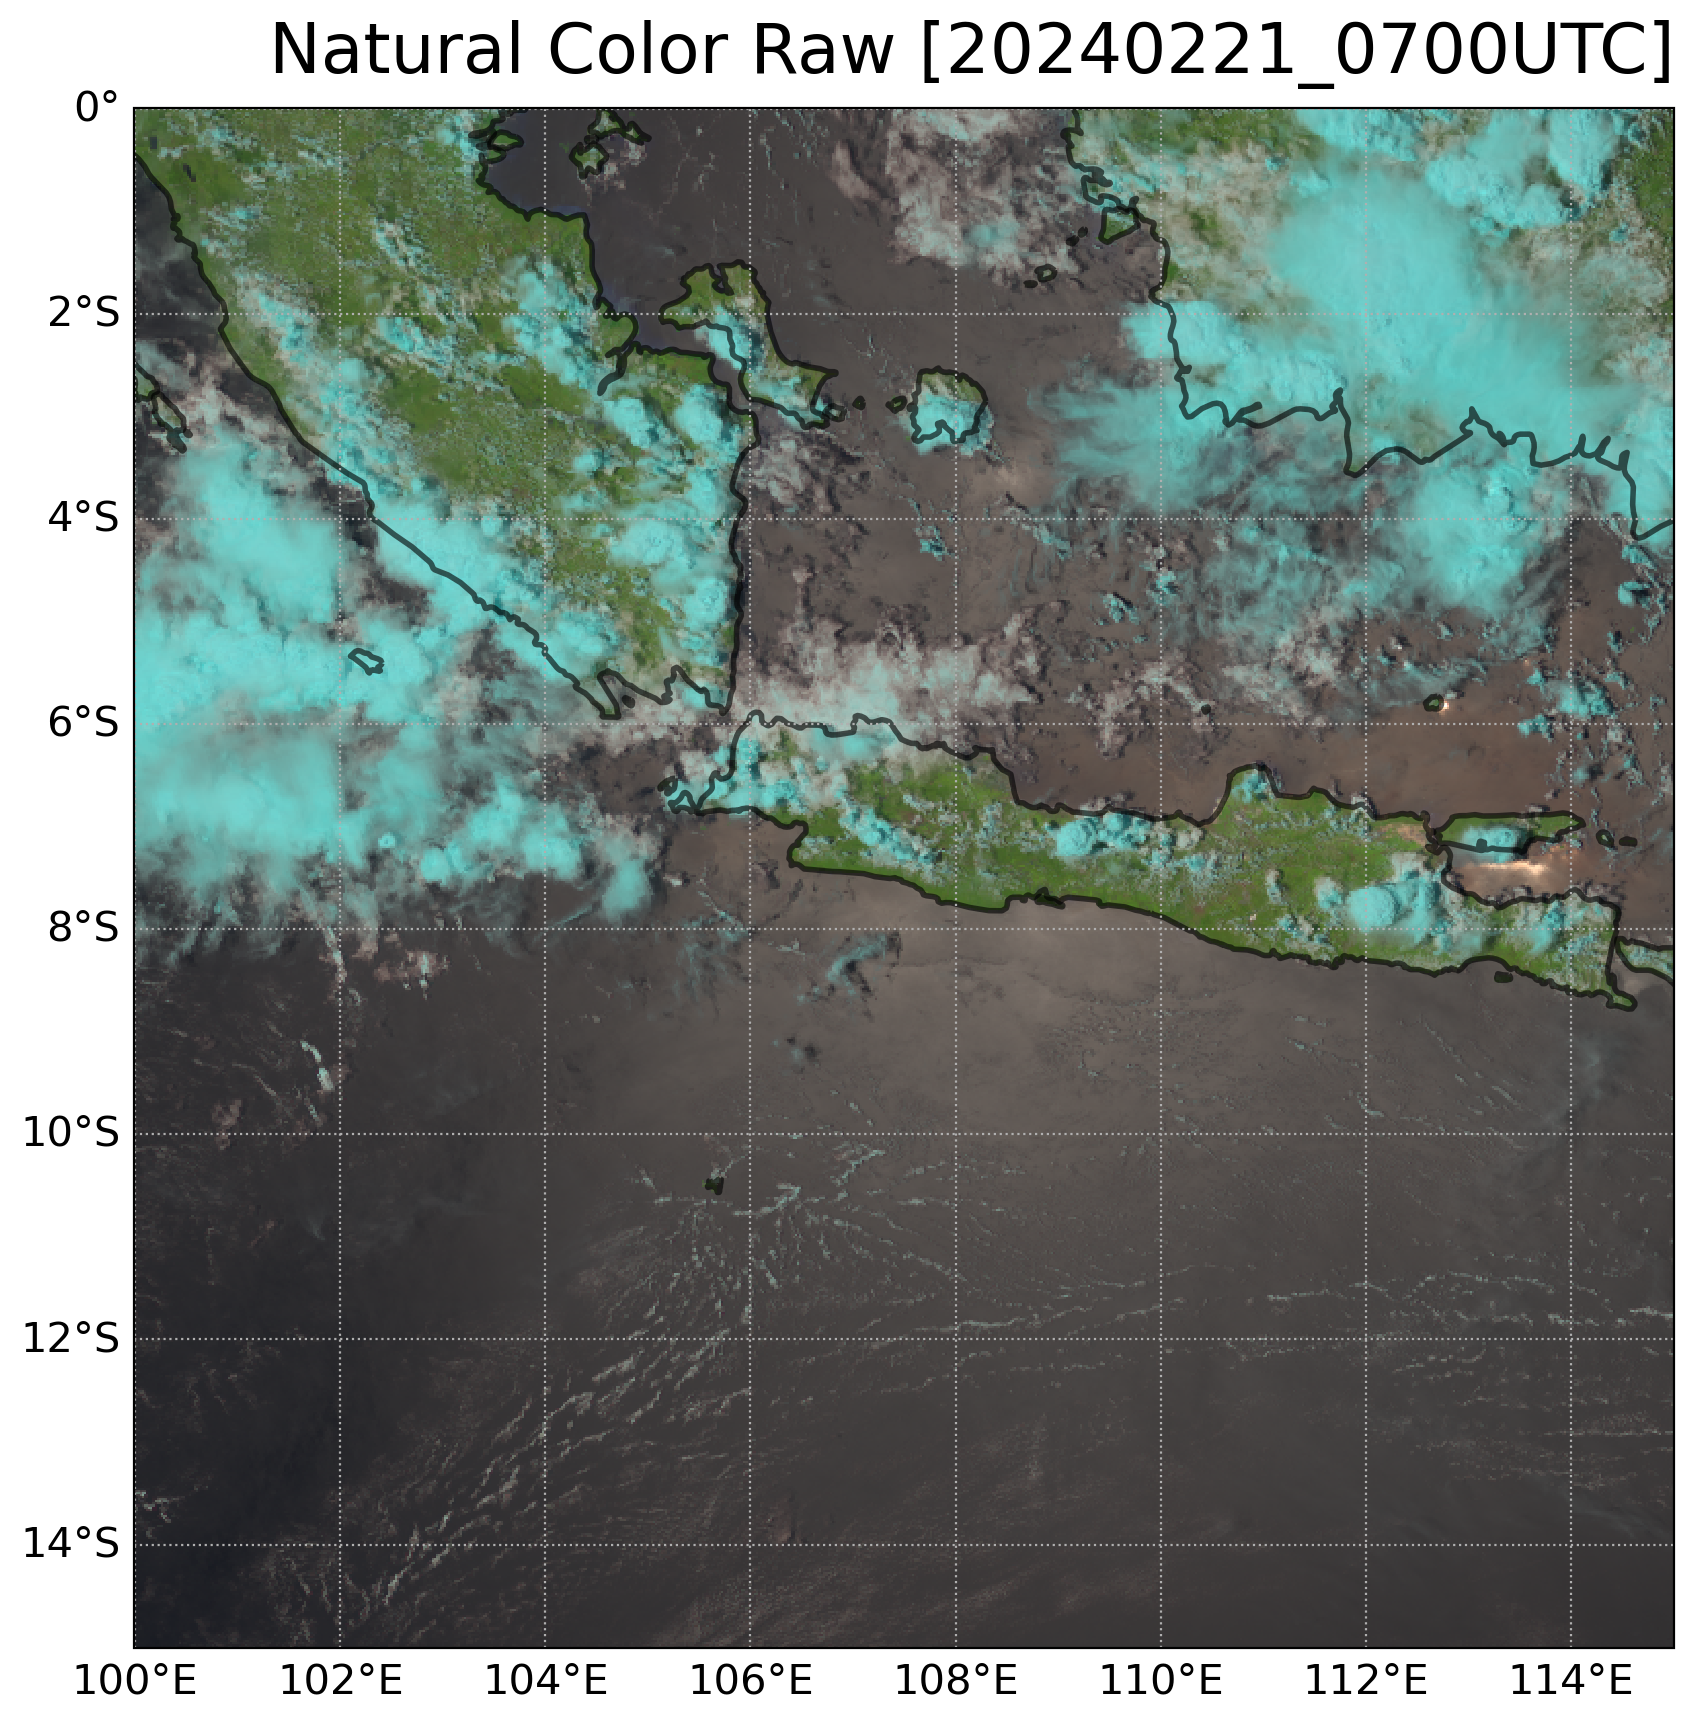

In [34]:
r_band = ds_crop['albedo_05']
g_band = ds_crop['albedo_04']
b_band = ds_crop['albedo_03']

comp = composites.GenericCompositor('natural_color_raw')
my_rgb = comp((r_band, g_band, b_band))
my_rgb=my_rgb.rename({'longitude': 'x','latitude': 'y'})

img = to_image(my_rgb)
enhancements.stretch(img,
                         stretch ='crude',
                         min_stretch = [0,0,0],
                         max_stretch = [0.99,1.2,1.2])
img.gamma(1.8)
img_data = img.data

plt.figure(figsize=(10,10), dpi=200)
ax=plt.axes(projection=cartopy.crs.PlateCarree())

img_data.plot.imshow(transform=cartopy.crs.PlateCarree(),
                         vmin=0,
                         vmax=1,
                         rgb='bands')

ax.coastlines('10m', color='black',linewidth=2,alpha=0.6)
gl = ax.gridlines(draw_labels=True,linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
    
plt.title('Natural Color Raw [20240221_0700UTC]', loc='right',fontsize=25)
plt.show()
#fig.savefig('Natural.svg',dpi=300,orientation='landscape', bbox_inches='tight')